In [21]:
from vampyr import vampyr3d as vp
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import scipy.integrate as integrate
from scipy.special import legendre, laguerre, erf, gamma
from scipy.special import gamma
from scipy.constants import hbar

mra = vp.MultiResolutionAnalysis(box=[-20,20], order=7)
prec = 1.0e-4
origin = [0.1, 0.2, 0.3]

print(mra)

                    MultiResolution Analysis                    
----------------------------------------------------------------
 polynomial order      : 7
 polynomial type       : Interpolating
----------------------------------------------------------------
 total boxes           : 8
 boxes                 : [          2           2           2 ]
 unit lengths          : [  20.000000   20.000000   20.000000 ]
 scaling factor        : [   1.250000    1.250000    1.250000 ]
 lower bounds          : [ -20.000000  -20.000000  -20.000000 ]
 upper bounds          : [  20.000000   20.000000   20.000000 ]
 total length          : [  40.000000   40.000000   40.000000 ]



0.5000156216290343 -0.5000133202791833


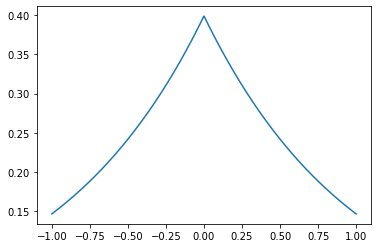

In [22]:
# H atom (almost) according to wikipedia
# Normalization not considered
# Exponential coeffcient C=1 (wikipedia coeff is not compatible with eigensolution)
# Limited to ground state for now (some formulas are however more generic)
# So far the best general description for the 4-c H atom was in the Bethe&Salpeter book

c=137
alpha = 1.0/c
k = -1
l = 0
n = 1
m = 0.5
Z = 1

def compute_gamma(k,Z,alpha):
    return np.sqrt(k**2 - Z**2 * alpha**2)

def compute_dirac_energy(n,Z,k,alpha):
    gamma_factor = compute_gamma(k,Z,alpha)
    tmp1 = n - np.abs(k) + gamma_factor
    tmp2 = Z * alpha / tmp1
    tmp3 = 1 + tmp2**2
    return c**2 / np.sqrt(tmp3)
#
# Approx expression
#
#def compute_dirac_energy(n,Z,k,c):
#    tmp1 = 1.0/np.abs(k) - 3.0/(4*n)
#    tmp2 = 1 + tmp1 * Z**2 / (n * c**2)
#    return c**2 - tmp2 * Z**2 / (2*n**2)


def compute_norm_const(n, gamma_factor):
# THIS NORMALIZATION CONSTANT IS FROM WIKIPEDIA BUT IT DOES NOT AGREE WITH Bethe&Salpeter
    tmp1 = 2 * n * (n + gamma_factor)
    tmp2 = 1 / (gamma_factor * gamma(2 * gamma_factor))
    return np.sqrt(tmp2/tmp1)

def one_s_alpha(x,Z,alpha,gamma_factor):
    r = np.sqrt(x[0]**2 + x[1]**2 + x[2]**2)
    tmp1 = 1.0 + gamma_factor
    tmp4 = Z * alpha
    u = x/r
    lar =   tmp1
    sai =   tmp4 * u[2]
    sbr = - tmp4 * u[1]
    sbi =   tmp4 * u[0]
    return lar, 0, 0, 0, 0, sai, sbr, sbi

def one_s_alpha_comp(x,Z,alpha,gamma_factor,norm_const,comp):
    r = np.sqrt(x[0]**2 + x[1]**2 + x[2]**2)
    tmp2 = r ** (gamma_factor - 1)
    tmp3 = np.exp(-Z*r)
    values = one_s_alpha(x,Z,alpha,gamma_factor)
    return values[comp] * tmp2 * tmp3 * norm_const / np.sqrt(2*np.pi)
                
gamma_factor = compute_gamma(k,Z,alpha)
norm_const = compute_norm_const(n, gamma_factor)
energy = compute_dirac_energy(n,Z,k,alpha)
Ezora = 2*(energy-c**2)*c**2/(energy+c**2)
print(norm_const,Ezora)

x_plt = np.linspace(-1.0, 1.0, 1000)
y_plt = [one_s_alpha_comp([x,0.0,0.0],Z,alpha,gamma_factor,norm_const,0) for x in x_plt]
_ = plt.plot(x_plt, y_plt)

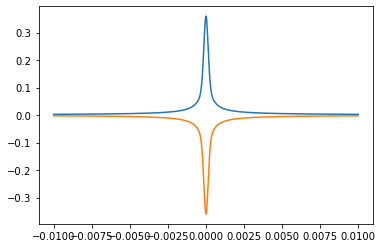

In [23]:
def u(r):
    u = erf(r)/r + (1/(3*np.sqrt(np.pi)))*(np.exp(-(r**2)) + 16*np.exp(-4*r**2))
    #erf(r) is an error function that is supposed to stop the potential well from going to inf.
    #if i remember correctly
    return u

def V(x):
    r = np.sqrt(x[0]**2 + x[1]**2 + x[2]**2)
#    c = 0.0435
    c = 0.000435 # ten times tighter nuclear potential
    f_bar = u(r/c)/c
    return f_bar

def kappa(x):
    temp = V(x) / (2 * c**2)
    return 1.0/(1-temp)

def one_m_kappa(x):
    temp = (2 * c**2) / V(x)
    return 1.0/(1-temp)

x_plt = np.linspace(-0.01, 0.01, 1000)
y1_plt = [kappa([x, 0.0, 0.0])-1 for x in x_plt]
y2_plt = [one_m_kappa([x, 0.0, 0.0]) for x in x_plt]
plt.plot(x_plt, y1_plt)
plt.plot(x_plt, y2_plt)

In [24]:
Peps = vp.ScalingProjector(mra,prec)
f = lambda x: V([x[0]-origin[0],x[1]-origin[1],x[2]-origin[2]])

print(f([0.5,0.5,0.5]))
V_tree = Z*Peps(f)

1.8569533817705184


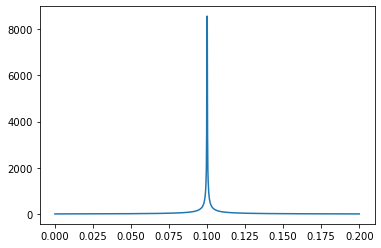

In [25]:
x_plt = np.linspace(0.0, 0.20, 1000)
nuclear_potential_plt = [V_tree([x, 0.2, 0.3]) for x in x_plt]
plt.plot(x_plt, nuclear_potential_plt)

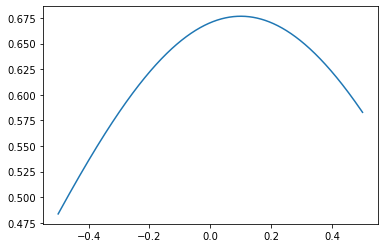

In [26]:
a_coeff = 3.0
b_coeff = np.sqrt(a_coeff/np.pi)**3
gauss = vp.GaussFunc(b_coeff, a_coeff, origin)
gauss_tree = vp.FunctionTree(mra)
vp.advanced.build_grid(out=gauss_tree, inp=gauss)
vp.advanced.project(prec=prec, out=gauss_tree, inp=gauss)
gauss_tree.normalize()

x_plt = np.linspace(-0.5, 0.5, 1000)
y_plt = [gauss_tree([x, 0.2, 0.3]) for x in x_plt]
plt.plot(x_plt, y_plt)

Energy  -0.4065838440196908 -0.2934161559803092
Energy  -0.49037881457327054 0.08379497055357976
Energy  -0.4981155659809777 0.00773675140770718
Energy  -0.49957645266986467 0.001460886688886967
Energy  -0.49990149082224855 0.0003250381523838909
Energy  -0.4999785174923506 7.702667010205694e-05
Energy  -0.49999728511210123 1.8767619750634006e-05
Energy  -0.5000019187951846 4.63368308334626e-06


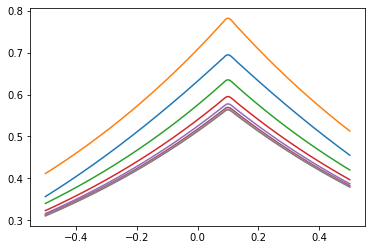

In [7]:
energy = -0.70;
energy_correction = 1.0;

phi_n = vp.FunctionTree(mra)
vp.advanced.copy_grid(phi_n, gauss_tree)
vp.advanced.copy_func(phi_n, gauss_tree)
phi_n.normalize()
#print(phi_n)
while np.abs(energy_correction) > prec/10:
    phi_n.normalize()
    phi_np1 = vp.FunctionTree(mra)
    temp1_tree = V_tree * phi_n
    
    mu = np.sqrt(-2*energy)
    H = vp.HelmholtzOperator(mra, mu, prec)
    phi_np1 = 2 * H(temp1_tree)
    delta_phi = vp.FunctionTree(mra)
    vp.advanced.add(prec/10, delta_phi, 1.0, phi_np1, -1.0, phi_n)
    temp2_tree = delta_phi * V_tree
    
    energy_correction = vp.dot(phi_np1, temp2_tree)/phi_np1.squaredNorm()
    phi_n = vp.FunctionTree(mra)
    vp.advanced.copy_grid(phi_n, phi_np1)
    vp.advanced.copy_func(phi_n, phi_np1)

    phi_n_plt = [phi_n([x, origin[1], origin[2]]) for x in x_plt]
    plt.plot(x_plt, phi_n_plt)

    while abs(energy_correction) > abs(energy): 
        energy_correction /= 2
    
    energy -= energy_correction
    print("Energy ", energy, energy_correction)

In [27]:
def init_function(orbital, function, component):
    vp.advanced.copy_grid(orbital[component], function)
    vp.advanced.copy_func(orbital[component], function)
    
def init_empty_orbital():
    orbital = {'Lar': vp.FunctionTree(mra),
               'Lai': vp.FunctionTree(mra),
               'Lbr': vp.FunctionTree(mra),
               'Lbi': vp.FunctionTree(mra),
               'Sar': vp.FunctionTree(mra),
               'Sai': vp.FunctionTree(mra),
               'Sbr': vp.FunctionTree(mra),
               'Sbi': vp.FunctionTree(mra)}
    for comp,func in orbital.items():
        func.setZero()
    return orbital

def init_large_components(orbital, phi_lar=None, phi_lai=None, phi_lbr=None, phi_lbi=None):
    nr_of_functions = 0
    if(phi_lar != None):
        nr_of_functions += 1
        init_function(orbital, phi_lar, 'Lar')
    if(phi_lai != None):
        nr_of_functions += 1
        init_function(orbital, phi_lai, 'Lai')
    if(phi_lbr != None):
        nr_of_functions += 1
        init_function(orbital, phi_lbr, 'Lbr')
    if(phi_lbi != None):
        nr_of_functions += 1
        init_function(orbital, phi_lbi, 'Lbi')
    if(nr_of_functions == 0):
        print("WARNING: Large components not initialized!")

def init_small_components(orbital):
    # initalize the small components based on the kinetic balance
    D = vp.ABGVDerivative(mra, 0.0, 0.0)
    grad_ar = vp.gradient(D, orbital['Lar'])
    grad_ai = vp.gradient(D, orbital['Lai'])
    grad_br = vp.gradient(D, orbital['Lbr'])
    grad_bi = vp.gradient(D, orbital['Lbi'])
    sar_tree = vp.FunctionTree(mra)    
    sai_tree = vp.FunctionTree(mra)    
    sbr_tree = vp.FunctionTree(mra)    
    sbi_tree = vp.FunctionTree(mra)    
    sum_ar = []
    sum_ar.append(tuple([ 0.5/c, grad_bi[0]]))
    sum_ar.append(tuple([-0.5/c, grad_br[1]]))
    sum_ar.append(tuple([ 0.5/c, grad_ai[2]]))
    vp.advanced.add(prec/10, sar_tree, sum_ar)
    sum_ai = []
    sum_ai.append(tuple([-0.5/c, grad_br[0]]))
    sum_ai.append(tuple([-0.5/c, grad_bi[1]]))
    sum_ai.append(tuple([-0.5/c, grad_ar[2]]))
    vp.advanced.add(prec/10, sai_tree, sum_ai)
    sum_br = []
    sum_br.append(tuple([ 0.5/c, grad_ai[0]]))
    sum_br.append(tuple([ 0.5/c, grad_ar[1]]))
    sum_br.append(tuple([-0.5/c, grad_bi[2]]))
    vp.advanced.add(prec/10, sbr_tree, sum_br)
    sum_bi = []
    sum_bi.append(tuple([-0.5/c, grad_ar[0]]))
    sum_bi.append(tuple([ 0.5/c, grad_ai[1]]))
    sum_bi.append(tuple([ 0.5/c, grad_br[2]]))
    vp.advanced.add(prec/10, sbi_tree, sum_bi)
    init_function(orbital, sar_tree, 'Sar')
    init_function(orbital, sai_tree, 'Sai')
    init_function(orbital, sbr_tree, 'Sbr')
    init_function(orbital, sbi_tree, 'Sbi')
    return
    
def compute_orbital_gradient(orbital):
    D = vp.ABGVDerivative(mra, 0.0, 0.0)
    orb_grad = {}
    for comp, func in orbital.items():
        orb_grad[comp] = vp.gradient(D, func) 
    return orb_grad

def grab_sign(comp, derivative):
    grab_table = {
        'Lar': ( 1, -1,  1), 
        'Lai': (-1, -1, -1), 
        'Lbr': ( 1,  1, -1), 
        'Lbi': (-1,  1,  1), 
        'Sar': ( 1, -1,  1), 
        'Sai': (-1, -1, -1), 
        'Sbr': ( 1,  1, -1), 
        'Sbi': (-1,  1,  1), 
    }
    return grab_table[comp][derivative]
    
def grab_coefficient(comp, derivative, global_factor = 1.0):
    grab_table = {
        'Lar': (c**2,c**2,c**2), 
        'Lai': (c**2,c**2,c**2),
        'Lbr': (c**2,c**2,c**2),
        'Lbi': (c**2,c**2,c**2),
        'Sar': (1, 1, 1), 
        'Sai': (1, 1, 1), 
        'Sbr': (1, 1, 1), 
        'Sbi': (1, 1, 1)
    }
    #return grab_table[comp][derivative] * global_factor
    return c
    
def grab_component(comp, derivative):
    grab_table = {
        'Lar': ('Sbi', 'Sbr', 'Sai'), 
        'Lai': ('Sbr', 'Sbi', 'Sar'), 
        'Lbr': ('Sai', 'Sar', 'Sbi'), 
        'Lbi': ('Sar', 'Sai', 'Sbr'), 
        'Sar': ('Lbi', 'Lbr', 'Lai'), 
        'Sai': ('Lbr', 'Lbi', 'Lar'), 
        'Sbr': ('Lai', 'Lar', 'Lbi'), 
        'Sbi': ('Lar', 'Lai', 'Lbr'), 
    }
    return grab_table[comp][derivative]
    
def assemble_vectors(orb, orb_grad, shift = 0.0):
    add_orbitals = {}
    for comp, func in orb.items():
        add_orbitals[comp] = []
        if('L' in comp):
            beta_factor = c**2 + shift
        else:
            beta_factor = -c**2 + shift            
        if(func.squaredNorm() > 0):
            add_orbitals[comp].append((beta_factor, func))
        for idx in range(3):
            comp_der = grab_component(comp, idx)
            comp_sign = grab_sign(comp, idx)
            comp_coeff = grab_coefficient(comp, idx)
            if(orb_grad[comp_der][idx].squaredNorm() > 0):
                tmp_tuple = (comp_sign * comp_coeff,orb_grad[comp_der][idx]) 
                add_orbitals[comp].append(tmp_tuple)
    return add_orbitals

def apply_dirac_hamiltonian(orbital, shift = 0.0):
    out_orbital = init_empty_orbital()
    orb_grad = compute_orbital_gradient(orbital)
    add_vectors = assemble_vectors(orbital, orb_grad, shift)
    for comp, func in out_orbital.items():
        vp.advanced.add(prec/10, func, add_vectors[comp])
    return out_orbital

def apply_potential(nuclear_potential, orbital):
    out_orbital = init_empty_orbital()
    for comp, func in orbital.items():
        if func.squaredNorm() > 0:
            vp.advanced.multiply(prec, out_orbital[comp], -1.0, nuclear_potential, func)
    return out_orbital

def add_orbitals(a, orb_a, b, orb_b):
    out_orb = init_empty_orbital()
    for comp, func in out_orb.items():
        func_a = orb_a[comp]
        func_b = orb_b[comp]
        if (func_a.squaredNorm() > 0 and func_b.squaredNorm() > 0):
            vp.advanced.add(prec/10, func, a, func_a, b, func_b)
        elif(func_a.squaredNorm() > 0):
            init_function(out_orb, func_a, comp)
            func *= a
        elif(func_b.squaredNorm() > 0):
            init_function(out_orb, func_b, comp)
            func *= b
        else:
            print('Warning: adding two empty trees')
    return out_orb

def scalar_product(orb_a, orb_b):
    out_real = 0
    out_imag = 0
    for comp in ['La','Lb','Sa','Sb']:
        factor = 1
#        if('S' in comp):
#            factor = c**2
        real_comp = comp + 'r'
        imag_comp = comp + 'i'
        ac = 0
        bd = 0
        ad = 0
        bc = 0
        func_a = orb_a[real_comp]
        func_b = orb_a[imag_comp]
        func_c = orb_b[real_comp]
        func_d = orb_b[imag_comp]
        if(func_a.squaredNorm() > 0 and func_c.squaredNorm() > 0):
           ac = vp.dot(func_a, func_c)
        if(func_b.squaredNorm() > 0 and func_d.squaredNorm() > 0):
           bd = vp.dot(func_b, func_d)
        if(func_a.squaredNorm() > 0 and func_d.squaredNorm() > 0):
           ad = vp.dot(func_a, func_d)
        if(func_b.squaredNorm() > 0 and func_c.squaredNorm() > 0):
           bc = vp.dot(func_b, func_c)
        out_real += (ac + bd) / factor
        out_imag += (ad - bc) / factor
    return out_real, out_imag

def init_1s_orbital(k,Z,alpha,origin):
    print(k,Z,alpha)
    orbital = init_empty_orbital()
    gamma_factor = compute_gamma(k,Z,alpha)
    norm_const = compute_norm_const(n, gamma_factor)
    idx = 0
    for comp, func in orbital.items():
        print('Now projecting component ',comp,idx,alpha,gamma_factor,norm_const)
        analytic_func = lambda x: one_s_alpha_comp([x[0]-origin[0],x[1]-origin[1],x[2]-origin[2]],Z,alpha,gamma_factor,norm_const,idx)
        vp.advanced.project(prec, func, analytic_func)
        idx += 1
    return orbital

def normalize_orbital(orbital):
    norm_sq, imag1 = scalar_product(orbital, orbital)
    norm = np.sqrt(norm_sq)
    rescale_orbital(orbital, 1.0/norm)

def apply_helmholtz(orbital, energy, c, prec):
    out_orbital = init_empty_orbital()
    mu = np.sqrt((c**4-energy**2)/c**2)
    H = vp.HelmholtzOperator(mra, mu, prec)
    for comp, func in orbital.items():
        if func.squaredNorm() > 0:
            vp.advanced.apply(prec, out_orbital[comp], H, func)
            out_orbital[comp] *= (-1.0/(2*np.pi))
    return out_orbital

def rescale_orbital(orbital, factor):
    for comp,func in orbital.items():
        if(func.squaredNorm() > 0):
            func *= factor
            
def compute_density(orbital):
    density = vp.FunctionTree(mra)
    add_vector = []
    for comp, func in orbital.items():
        if(func.squaredNorm() > 0):
            temp = vp.FunctionTree(mra)
            vp.advanced.multiply(prec, temp, 1.0, func, func)
            add_vector.append((1.0,temp))
    vp.advanced.add(prec/10, density, add_vector)
    return density


In [29]:
def print_orbital(orbital):
    print(orbital["Lar"])
    print(orbital["Lai"])
    print(orbital["Lbr"])
    print(orbital["Lbi"])
    print(orbital["Sar"])
    print(orbital["Sai"])
    print(orbital["Sbr"])
    print(orbital["Sbi"])

gaussian_orbital = init_empty_orbital()
init_large_components(gaussian_orbital,gauss_tree)
init_small_components(gaussian_orbital)
normalize_orbital(gaussian_orbital)
#density = compute_density(gaussian_orbital)
#x_plt = np.linspace(-1.0, 1.0, 1000)
#density_plt = [density([x, 0.2, 0.3]) for x in x_plt]
#_ = plt.plot(x_plt, density_plt)
hd_psi = apply_dirac_hamiltonian(gaussian_orbital)
v_psi = apply_potential(V_tree, gaussian_orbital)
add_psi = add_orbitals(1.0, hd_psi, 1.0, v_psi)
energy, imag = scalar_product(gaussian_orbital, add_psi)
print_orbital(add_psi)
print(energy, imag)


*FunctionTree: nn
  genNodes: 0
  square norm: 3.52257e+08
  root scale: -4
  order: 7
  nodes: 336
  endNodes: 295
  nodes per scale: 
    scale=-4  nodes=8
    scale=-3  nodes=64
    scale=-2  nodes=64
    scale=-1  nodes=64
    scale=0  nodes=64
    scale=1  nodes=8
    scale=2  nodes=8
    scale=3  nodes=8
    scale=4  nodes=8
    scale=5  nodes=8
    scale=6  nodes=8
    scale=7  nodes=8
    scale=8  nodes=8
    scale=9  nodes=8


*FunctionTree: nn
  genNodes: 0
  square norm: 1.80547e-20
  root scale: -4
  order: 7
  nodes: 632
  endNodes: 554
  nodes per scale: 
    scale=-4  nodes=8
    scale=-3  nodes=64
    scale=-2  nodes=64
    scale=-1  nodes=152
    scale=0  nodes=224
    scale=1  nodes=120


*FunctionTree: nn
  genNodes: 0
  square norm: 1.98314e-20
  root scale: -4
  order: 7
  nodes: 568
  endNodes: 498
  nodes per scale: 
    scale=-4  nodes=8
    scale=-3  nodes=64
    scale=-2  nodes=64
    scale=-1  nodes=144
    scale=0  nodes=168
    scale=1  nodes=120


*Functi

In [9]:
exact_orbital = init_1s_orbital(k,Z,alpha,origin)

-1 1 0.007297352573756914
Now projecting component  Lar 0 0.007297352573756914 0.9999733739682344 0.5000156134224146
Now projecting component  Lai 1 0.007297352573756914 0.9999733739682344 0.5000156134224146
Now projecting component  Lbr 2 0.007297352573756914 0.9999733739682344 0.5000156134224146
Now projecting component  Lbi 3 0.007297352573756914 0.9999733739682344 0.5000156134224146
Now projecting component  Sar 4 0.007297352573756914 0.9999733739682344 0.5000156134224146
Now projecting component  Sai 5 0.007297352573756914 0.9999733739682344 0.5000156134224146
Now projecting component  Sbr 6 0.007297352573756914 0.9999733739682344 0.5000156134224146
Now projecting component  Sbi 7 0.007297352573756914 0.9999733739682344 0.5000156134224146


In [10]:
normalize_orbital(exact_orbital)
print(exact_orbital['Lar']([0.1,0.2,0.3]))

0.5615871711116863


In [30]:
orbital = gaussian_orbital
orbital_error = 1
while orbital_error > prec:
#for i in range(1):    
    hd_psi = apply_dirac_hamiltonian(orbital)
    v_psi = apply_potential(V_tree, orbital)
    add_psi = add_orbitals(1.0, hd_psi, 1.0, v_psi)
    energy, imag = scalar_product(orbital, add_psi)
    print('Energy',energy)
    tmp = apply_helmholtz(v_psi, energy, c, prec)
    new_orbital = apply_dirac_hamiltonian(tmp, energy)
    normalize_orbital(new_orbital)
    delta_psi = add_orbitals(1.0, new_orbital, -1.0, orbital)
    orbital_error, imag = scalar_product(delta_psi, delta_psi)
    print('Error',orbital_error)
    orbital = new_orbital
    


hd_psi = apply_dirac_hamiltonian(orbital)
v_psi = apply_potential(V_tree, orbital)
add_psi = add_orbitals(1.0, hd_psi, 1.0, v_psi)
energy, imag = scalar_product(orbital, add_psi)
print('Energy',energy)

Energy 18768.8581933387
Error 0.36483622794224463
Energy 18768.503802409858
Error 0.002485072379088421
Energy 18768.50016021784
Error 0.00023347032546467954
Energy 18768.49990292878
Error 2.409216839674893e-05


In [40]:
print(gauss_tree([0.5,0.5,0.5]))
print(gaussian_orbital["Lar"]([0.5,0.5,0.5]))

print("gaussian_orbital")
print(gaussian_orbital["Lar"])
print(gaussian_orbital["Lai"])
print(gaussian_orbital["Lbr"])
print(gaussian_orbital["Lbi"])
print(gaussian_orbital["Sar"])
print(gaussian_orbital["Sai"])
print(gaussian_orbital["Sbr"])
print(gaussian_orbital["Sbi"])

print("hd_psi")
print(hd_psi["Lar"])
print(hd_psi["Lai"])
print(hd_psi["Lbr"])
print(hd_psi["Lbi"])
print(hd_psi["Sar"])
print(hd_psi["Sai"])
print(hd_psi["Sbr"])
print(hd_psi["Sbi"])

print("v_psi")
print(v_psi["Lar"])
print(v_psi["Lai"])
print(v_psi["Lbr"])
print(v_psi["Lbi"])
print(v_psi["Sar"])
print(v_psi["Sai"])
print(v_psi["Sbr"])
print(v_psi["Sbi"])

print("add_psi")
print(add_psi["Lar"])
print(add_psi["Lai"])
print(add_psi["Lbr"])
print(add_psi["Lbi"])
print(add_psi["Sar"])
print(add_psi["Sai"])
print(add_psi["Sbr"])
print(add_psi["Sbi"])


0.5162385294183164
0.5162289098118915
gaussian_orbital

*FunctionTree: nn
  genNodes: 0
  square norm: 0.999963
  root scale: -4
  order: 7
  nodes: 264
  endNodes: 232
  nodes per scale: 
    scale=-4  nodes=8
    scale=-3  nodes=64
    scale=-2  nodes=64
    scale=-1  nodes=64
    scale=0  nodes=64


*FunctionTree: nn
  genNodes: 0
  square norm: 0
  root scale: -4
  order: 7
  nodes: 8
  endNodes: 8
  nodes per scale: 
    scale=-4  nodes=8


*FunctionTree: nn
  genNodes: 0
  square norm: 0
  root scale: -4
  order: 7
  nodes: 8
  endNodes: 8
  nodes per scale: 
    scale=-4  nodes=8


*FunctionTree: nn
  genNodes: 0
  square norm: 0
  root scale: -4
  order: 7
  nodes: 8
  endNodes: 8
  nodes per scale: 
    scale=-4  nodes=8


*FunctionTree: nn
  genNodes: 0
  square norm: 0
  root scale: -4
  order: 7
  nodes: 8
  endNodes: 8
  nodes per scale: 
    scale=-4  nodes=8


*FunctionTree: nn
  genNodes: 0
  square norm: 1.24226e-05
  root scale: -4
  order: 7
  nodes: 264
  endNodes: 

In [ ]:
v_psi = apply_potential(V_tree, gaussian_orbital)
tmp = apply_dirac_hamiltonian(v_psi, energy)
out_orb = apply_helmholtz(tmp, energy, c, prec)
normalize_orbital(out_orb)

In [ ]:
#for comp, func in add_psi.items():
#    if (func.getSquareNorm() > 0):
#        refine_grid(func,1)

fig, axs = plt.subplots(2,2,figsize=(10, 10))
#axs[0,0].set_box_aspect(1)
#axs[0,1].set_box_aspect(1)
#axs[1,0].set_box_aspect(1)
#axs[1,1].set_box_aspect(1)
x_plt = np.linspace(-1, 1, 1000)
orbital_plt = {}
exact_plt = {}
out_plt = {}
orb_plt = {}
add_psi_plt = {}
exact_plt['Lar']   = [exact_orbital['Lar'](   [x+origin[0],   origin[1],   origin[2]]) for x in x_plt]
exact_plt['Sai']   = [exact_orbital['Sai'](   [  origin[0],   origin[1], x+origin[2]]) for x in x_plt]
exact_plt['Sbr']   = [exact_orbital['Sbr'](   [  origin[0], x+origin[1],   origin[2]]) for x in x_plt]
exact_plt['Sbi']   = [exact_orbital['Sbi'](   [x+origin[0],   origin[1],   origin[2]]) for x in x_plt]
out_plt['Lar']     = [out_orb['Lar'](         [x+origin[0],   origin[1],   origin[2]]) for x in x_plt]
out_plt['Sai']     = [out_orb['Sai'](         [  origin[0],   origin[1], x+origin[2]]) for x in x_plt]
out_plt['Sbr']     = [out_orb['Sbr'](         [  origin[0], x+origin[1],   origin[2]]) for x in x_plt]
out_plt['Sbi']     = [out_orb['Sbi'](         [x+origin[0],   origin[1],   origin[2]]) for x in x_plt]
orb_plt['Lar']     = [orbital['Lar'](         [x+origin[0],   origin[1],   origin[2]]) for x in x_plt]
orb_plt['Sai']     = [orbital['Sai'](         [  origin[0],   origin[1], x+origin[2]]) for x in x_plt]
orb_plt['Sbr']     = [orbital['Sbr'](         [  origin[0], x+origin[1],   origin[2]]) for x in x_plt]
orb_plt['Sbi']     = [orbital['Sbi'](         [x+origin[0],   origin[1],   origin[2]]) for x in x_plt]
orbital_plt['Lar'] = [gaussian_orbital['Lar']([x+origin[0],   origin[1],   origin[2]]) for x in x_plt]
orbital_plt['Sai'] = [gaussian_orbital['Sai']([  origin[0],   origin[1], x+origin[2]]) for x in x_plt]
orbital_plt['Sbr'] = [gaussian_orbital['Sbr']([  origin[0], x+origin[1],   origin[2]]) for x in x_plt]
orbital_plt['Sbi'] = [gaussian_orbital['Sbi']([x+origin[0],   origin[1],   origin[2]]) for x in x_plt]
add_psi_plt['Lar'] = [add_psi['Lar'](         [x+origin[0],   origin[1],   origin[2]]) for x in x_plt]
add_psi_plt['Sai'] = [add_psi['Sai'](         [  origin[0],   origin[1], x+origin[2]]) for x in x_plt]
add_psi_plt['Sbr'] = [add_psi['Sbr'](         [  origin[0], x+origin[1],   origin[2]]) for x in x_plt]
add_psi_plt['Sbi'] = [add_psi['Sbi'](         [x+origin[0],   origin[1],   origin[2]]) for x in x_plt]
#plt.plot(x_plt, [add_psi_plt['Lar'][i]/orbital_plt['Lar'][i] for i in range(1000)])
#axs[0,0].plot(x_plt, add_psi_plt['Lar'],label='add_psi')
#axs[0,0].plot(x_plt, orbital_plt['Lar'],label='gaussian')
axs[0,0].plot(x_plt, exact_plt['Lar'],label='exact')
#axs[0,0].plot(x_plt, out_plt['Lar'],label='out (1 iter)')
axs[0,0].plot(x_plt, orb_plt['Lar'],label='out (err 10^-4)')
axs[0,0].legend()
#axs[0,1].plot(x_plt, add_psi_plt['Sai'],label='add_psi')
#axs[0,1].plot(x_plt, orbital_plt['Sai'],label='gaussian')
axs[0,1].plot(x_plt, exact_plt['Sai'],label='exact')
#axs[0,1].plot(x_plt, out_plt['Sai'],label='out (1 iter)')
axs[0,1].plot(x_plt, orb_plt['Sai'],label='out (err 10^-4)')
axs[0,1].legend()
#axs[1,0].plot(x_plt, add_psi_plt['Sbr'],label='add_psi')
#axs[1,0].plot(x_plt, orbital_plt['Sbr'],label='gaussian')
axs[1,0].plot(x_plt, exact_plt['Sbr'],label='exact')
#axs[1,0].plot(x_plt, out_plt['Sbr'],label='out (1 iter)')
axs[1,0].plot(x_plt, orb_plt['Sbr'],label='out (err 10^-4)')
axs[1,0].legend()
#axs[1,1].plot(x_plt, add_psi_plt['Sbi'],label='add_psi')
#axs[1,1].plot(x_plt, orbital_plt['Sbi'],label='gaussian')
axs[1,1].plot(x_plt, exact_plt['Sbi'],label='exact')
#axs[1,1].plot(x_plt, out_plt['Sbi'],label='out (1 iter)')
axs[1,1].plot(x_plt, orb_plt['Sbi'],label='out (err 10^-4)')
axs[1,1].legend()
#axs[0,0].set_ylim(0, 1)
#axs[0,1].set_ylim(-0.01, 0.01)
#axs[1,0].set_ylim(-0.01, 0.01)
#axs[1,1].set_ylim(-0.01, 0.01)
#plt.plot(x_plt, y_plt)

In [ ]:
hd_psi = apply_dirac_hamiltonian(orbital)
v_psi = apply_potential(V_tree, orbital)
add_psi = add_orbitals(1.0, hd_psi, 1.0, v_psi)
energy, imag = scalar_product(orbital, add_psi)
print('Converged energy',energy-c**2)
print(orbital['Lar']([0.1,0.2,0.3]))

In [ ]:
hd_psi = apply_dirac_hamiltonian(exact_orbital)
v_psi = apply_potential(V_tree, exact_orbital)
add_psi = add_orbitals(1.0, hd_psi, 1.0, v_psi)
energy, imag = scalar_product(exact_orbital, add_psi)
print('Exact energy',energy-c**2)
print("Analytical energy", compute_dirac_energy(n,Z,k,alpha)-c**2)
print(exact_orbital['Lar']([0.1,0.2,0.3]))

In [ ]:
hd_psi = apply_dirac_hamiltonian(gaussian_orbital)
v_psi = apply_potential(V_tree, gaussian_orbital)
add_psi = add_orbitals(1.0, hd_psi, 1.0, v_psi)
energy, imag = scalar_product(gaussian_orbital, add_psi)
print('Starting guess energy',energy)
print(gaussian_orbital['Lar']([0.1,0.2,0.3]))

In [ ]:
print(exact_orbital["Lar"])